In [1]:
import pandas as pd
import re
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [19]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 4.62 s, sys: 6.38 s, total: 11 s
Wall time: 18.3 s


(199677, 5)

In [4]:
df_news_final_project.head(2)

url  \
0  http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/   
1                                                                           http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html   

         date language  \
0  2020-02-26       en   
1  2021-07-05       en   

                                                                                                                                                           title  \
0  LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis   
1                                                                              Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Avaliable CPU cores: {num_processors}')

Avaliable CPU cores: 4


In [4]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 3 workers


Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

In [20]:
def clean_text_data(text):
    # Remove tabs and carriage returns
    text = re.sub(r'(?:\t|\r)', '', text)
    # Replace newline characters with a space
    text = re.sub(r'(?:\n)', ' ', text)
    # Remove URLs that start with 'http', 'https', 'www' or contain '@'
    text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+', '', text)
    # Remove special characters
    text = re.sub(r'(?:\xa0|\xad|\'|\\)', '', text)
    # Remove anything that's not a letter, number, some punctuation, or space
    # Keeps alphanumeric characters, basic punctuation, and newlines
    text = re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    # Remove backslashes
    text = re.sub(r"\\", " ", text)
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)  
    # Remove single quotes
    text = re.sub(r"\'", "", text)
    # Remove leading white spaces
    text = text.lstrip()

    return text


In [21]:
# Apply the cleaning function in parallel
df_news_final_project['cleaned_text'] = df_news_final_project['text'].apply(clean_text_data)

In [22]:
df_news_final_project['cleaned_text'].head(2) 

0    LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope   Casetext Inc , Catalyst Repository Systems, eBREVIA   Galus Australis            Galus Australis  BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci Tech  Wednesday, February 26 2020  Trending  Needle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020 2026  Apollo Games, Sony, Aristocrat Leisure, IGT Infectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher, BD, Roche Diagnostics Veterinary Dental X ray Generators Market Comprehensive Study by Companies Planmeca, Midmark, Medicatech USA Veterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik, Gowllands Limited Veterinary Holters Market Comprehensive Stu

In [23]:
# remove irrelevant parts of the text
def remove_endings(text, ending_words):
    for ending_word in ending_words:
        idx = text.find(ending_word)
        if idx != -1:
            return text[:idx]
    return text

In [24]:
endings =  ['READ MORE：','View original content','Related Content','Read More','Related Stories',
            'Share This To World','Read more','Share this article','Related topics',
            'Related posts','Related News','Media Conact','For more information','View More','ExploreMore',
            'For More Information','Join Us','More information is available','Media Contact','Follow Us',
            'The views, opinions and statements in the press release','Next Article','More Stories',
            'This release was drafted by','About Us:','Trending:','Previous post:','Most Popular',
            'Related:','RELATED ARTICLES','Article Topic Follows','Subscriber Exclusives','Also read', 
            'Sponsored Content:','Author Bio','For Further Reading','Copyright Information', 'Connect with Us',
            'Further Details:','Follow on Social Media','Sign Up for Our Newsletter','Subscribe Now']

In [25]:
df_news_final_project['cleaned_text_noEND'] = df_news_final_project['cleaned_text'].apply(lambda x: remove_endings(x, endings))

In [26]:
# split the text into sentences by punctuation
df_news_final_project['cleaned_text_split'] = df_news_final_project['cleaned_text_noEND'].str.split('[.!?;,]')

In [27]:
df_news_final_project['cleaned_text_split'].head(2)

0    [LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope   Casetext Inc ,  Catalyst Repository Systems,  eBREVIA   Galus Australis            Galus Australis  BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci Tech  Wednesday,  February 26 2020  Trending  Needle Counters Market Comprehensive Study by Companies Medline Industries,  Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries,  BD,  Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020 2026  Apollo Games,  Sony,  Aristocrat Leisure,  IGT Infectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher,  BD,  Roche Diagnostics Veterinary Dental X ray Generators Market Comprehensive Study by Companies Planmeca,  Midmark,  Medicatech USA Veterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik,  Gowllands Limited Veterinary Holters Market Co

In [28]:
# Define a function to further clean and process text data
def process_text_data(df, column_name, max_length=400):
    # Filter out items longer than max_length
    df[column_name + '_filtered'] = df[column_name].apply(lambda x: [item for item in x if len(item) < max_length])

    # Identify and store items that were removed
    df[column_name + '_removed'] = df[column_name].apply(lambda x: [item for item in x if len(item) >= max_length])

    # Concatenate the filtered items into a single string
    df[column_name + '_concatenated'] = df[column_name + '_filtered'].apply(lambda x: ' '.join(x).strip())

    # Replace multiple spaces with a single space
    df[column_name + '_concatenated'] = df[column_name + '_concatenated'].str.replace(' +', ' ', regex=True)

    return df

df_news_final_project = process_text_data(df_news_final_project, 'cleaned_text_split')


In [29]:
df_news_final_project['cleaned_text_split_concatenated'].head(2)

0    LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020 2026 Apollo Games Sony Aristocrat Leisure IGT Infectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher BD Roche Diagnostics Veterinary Dental X ray Generators Market Comprehensive Study by Companies Planmeca Midmark Medicatech USA Veterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik Gowllands Limited Veterinary Holters Market Comprehensive Study by Companies Dextronix Nasiff As

In [30]:
df_news_final_project['cleaned_text_split_removed'].head(2)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Discard irrelevant articles

In [31]:
df_news_final_project.shape

(199677, 11)

In [32]:
keywords = ['data science','Data Science','machine learning','Machine Learning','artificial intelligence',
            'Artificial Intelligence','AI','ML','DS']

In [33]:
# only remain the ones with keywords
pattern = '|'.join(keywords)
df_news_final_project_filtered = df_news_final_project[df_news_final_project['cleaned_text_split_concatenated'].str.contains(pattern, case=False, na=False)]

In [34]:
df_news_final_project_filtered.shape

(194431, 11)

In [ ]:
df_news_final_project_filtered.to_parquet('df_news_final_project_filtered.parquet')

In [23]:
# Sample 10% of the DataFrame
sampled_df = df_news_final_project_filtered.sample(frac=0.2, random_state=42)

In [24]:
sampled_df.shape

(38886, 11)

In [25]:
sampled_df.head(2)

url  \
160448  https://www.nbc12.com/prnewswire/2022/07/19/globaldata-ranked-zac-cognitive-explainable-ai-artificial-intelligence-image-recognition-startup-top-5-companies-worldwide-web-30-fundamental-category/   
138942                                                                           https://forextv.com/top-news/the-nft-announces-that-space-striker-ai-has-been-approved-by-apple-app-store-and-google-play/   

              date language  \
160448  2022-07-19       en   
138942  2023-08-08       en   

                                                                                                                                                                            title  \
160448  GlobalData ranked ZAC, the Cognitive Explainable-AI (Artificial Intelligence) Image Recognition startup, in top 5 companies worldwide, for a Web 3.0 fundamental category   
138942                                                                     The NFT Announces that Space Striker AI has Been Approved by Apple App Store and Google Play - ForexTV   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [26]:
sampled_df.to_parquet('sampled_df.parquet')

Kernel died, so restart from here.

LDA

In [7]:
sampled_df = pd.read_parquet('sampled_df.parquet')

In [8]:
sampled_df.shape

(38886, 11)

In [9]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [10]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = sampled_df['cleaned_text_split_concatenated'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 39.3 s, sys: 407 ms, total: 39.7 s
Wall time: 39.7 s


In [11]:
%%time
# Remove Stopwords, Make n-grams and Lemmatize

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 1min 28s, sys: 420 ms, total: 1min 29s
Wall time: 1min 29s


In [12]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
   return [trigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 4.51 ms, sys: 12 µs, total: 4.52 ms
Wall time: 22.1 ms
Compiler : 355 ms


In [16]:
#!python -m spacy download en_core_web_sm


In [17]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [18]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

['globaldata_ranke', 'zac', 'cognitive_explainable', 'ai', 'artificial_intelligence', 'image_recognition', 'startup', 'top_companie', 'worldwide', 'cognitive_explainable', 'ai', 'artificial_intelligence', 'image_recognition', 'startup', 'top_companie', 'worldwide', 'web_fundamental', 'pioneer_cognitive', 'explainable_ai', 'artificial_intelligence', 'cognitive_xai', 'base', 'concept', 'learning_software', 'startup', 'top_companie', 'fundamental_category', 'web', 'rd_iteration', 'internet', 'report_title', 'internets_next', 'revolution', 'web_unlock', 'decentralize', 'intelligent_internet', 'zac', 'major', 'data_analytic', 'consulting_company', 'public_company', 'zac_cognition', 'based_explainable', 'ai', 'cognitive_xai', 'variety', 'complex_image', 'object_recognition', 'application', 'vertical', 'different_industrie', 'top_companie', 'fundamental_category', 'web', 'us_air', 'force', 'aerial_vision', 'bosch_bsh', 'big', 'appliance_maker', 'demonstrate', 'major_ai', 'machine_learne', 'ml

In [19]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 15.7 s, sys: 176 ms, total: 15.9 s
Wall time: 15.9 s


In [20]:
len(data_lemmatized)

38886

In [21]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model_news = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda_news = CoherenceModel(model=lda_model_news, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda_news.get_coherence()

In [22]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 2
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
#alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
#beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')
#beta.append('auto') 
beta = ['auto']# Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [ #gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
                #gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
                #gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
corpus_title = ['100% Corpus']
#corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Corpus':[]
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                model_results['Corpus'].append(corpus_title[i])
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning_news = pd.DataFrame(model_results)

LDA will execute 10 iterations
Completed model based on 2 LDA topics. Finished 10.0% of LDA runs
Execution time to calculate for topic 2: 0hour:2min:17sec
Completed model based on 4 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 4: 0hour:2min:26sec
Completed model based on 6 LDA topics. Finished 30.0% of LDA runs
Execution time to calculate for topic 6: 0hour:2min:48sec
Completed model based on 8 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 8: 0hour:3min:5sec
Completed model based on 10 LDA topics. Finished 50.0% of LDA runs
Execution time to calculate for topic 10: 0hour:4min:2sec
Completed model based on 12 LDA topics. Finished 60.0% of LDA runs
Execution time to calculate for topic 12: 0hour:4min:41sec
Completed model based on 14 LDA topics. Finished 70.0% of LDA runs
Execution time to calculate for topic 14: 0hour:5min:23sec
Completed model based on 16 LDA topics. Finished 80.0% of LDA runs
Execution time to calculate fo

In [23]:
lda_tuning_news.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence,Corpus
3,8,asymmetric,auto,0.455689,100% Corpus
7,16,asymmetric,auto,0.444644,100% Corpus
6,14,asymmetric,auto,0.443830,100% Corpus
5,12,asymmetric,auto,0.437887,100% Corpus
1,4,asymmetric,auto,0.422003,100% Corpus
8,18,asymmetric,auto,0.416424,100% Corpus
4,10,asymmetric,auto,0.415306,100% Corpus
9,20,asymmetric,auto,0.413037,100% Corpus
2,6,asymmetric,auto,0.406864,100% Corpus
0,2,asymmetric,auto,0.311976,100% Corpus


In [24]:
lda_tuning_news.to_csv('lda_tuning_news.csv', index=False)

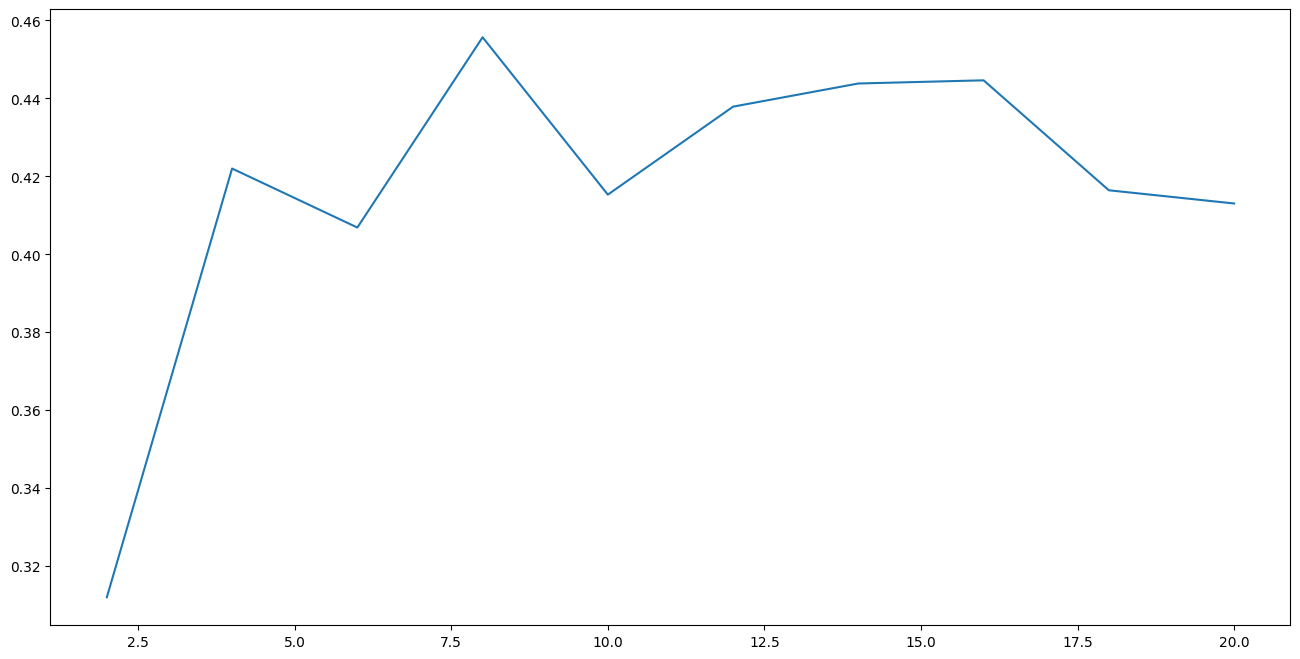

In [25]:
#plot data 
plt.figure(figsize=(16,8))
plt.plot(lda_tuning_news['Topics'], lda_tuning_news['Coherence'])

In [27]:
%%time

tuned_lda_model_news = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=8,
                       random_state=100,
                       passes=10,
                       alpha='asymmetric',
                       eta='auto',
                       workers = workers)

CPU times: user 1min 59s, sys: 3.7 s, total: 2min 3s
Wall time: 2min 19s


In [28]:
%%time

lda_display_news = gensimvis.prepare(tuned_lda_model_news, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_news)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


CPU times: user 18.4 s, sys: 8.69 s, total: 27.1 s
Wall time: 28.3 s


In [32]:
# Saving the visualization to a file in the current working directory
pyLDAvis.save_html(lda_display_news, 'lda_visualization.html')

In [33]:
from IPython.core.display import HTML

def show_lda_vis(lda_display, width=1200, height=800):
    """ Display LDA visualization with specified width and height """
    html = pyLDAvis.prepared_data_to_html(lda_display)
    display(HTML(f'<div style="width: {width}px; height: {height}px;">{html}</div>'))

# Generate the LDA visualization
lda_display_news = gensimvis.prepare(tuned_lda_model_news, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')

# Display the visualization with increased size
show_lda_vis(lda_display_news, width=1200, height=800)


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


TF-IDF

In [39]:
#!pip install ktrain

In [36]:
#!pip install torch
#!pip install torch torchvision torchaudio

KTrain

In [5]:
import ktrain

/opt/conda/lib/python3.10/site-packages/ktrain/imports.py:59: UserWarning: TensorFlow is not installed and will be needed if training neural networks, but non-TensorFlow features in ktrain can still be used. See https://github.com/amaiya/ktrain/blob/master/README.md
  warnings.warn(TF_WARNING)
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [6]:
sampled_df = pd.read_parquet('sampled_df.parquet')

In [7]:
%%time
#ktrain
texts_total = sampled_df['cleaned_text_split_concatenated'].tolist() 

CPU times: user 1.78 ms, sys: 0 ns, total: 1.78 ms
Wall time: 1.79 ms


In [8]:
sampled_df['cleaned_text_split_concatenated'].head(2)

160448                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [9]:
%%time
tm = ktrain.text.get_topic_model(
    texts=texts_total, 
    n_topics=8, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 2min 16s, sys: 33.6 s, total: 2min 49s
Wall time: 2min 8s


In [10]:
tm.print_topics()

topic 0 | news ago video year india world day years live says
topic 1 | prnewswire solutions global industry platform digital company business companies leading
topic 2 | market report global analysis growth industry key forecast research trends
topic 3 | learning medical research machine edge based computer patients nvidia health
topic 4 | like people use human chatgpt work used just says using
topic 5 | google chatgpt users news search microsoft content email openai app
topic 6 | customer cloud customers platform business time learning models generative service
topic 7 | company stock year shares billion million investment price companies insurance


In [12]:
%%time
# Compute the Document-Topic Matrix
tm.build(texts_total, threshold=0.25)

done.
CPU times: user 31.2 s, sys: 5.29 s, total: 36.5 s
Wall time: 29.9 s


In [13]:
#list the topics by document count:

tm.print_topics(show_counts=True)

topic:4 | count:7681 | like people use human chatgpt work used just says using
topic:1 | count:6730 | prnewswire solutions global industry platform digital company business companies leading
topic:5 | count:4953 | google chatgpt users news search microsoft content email openai app
topic:0 | count:4887 | news ago video year india world day years live says
topic:6 | count:4370 | customer cloud customers platform business time learning models generative service
topic:2 | count:3825 | market report global analysis growth industry key forecast research trends
topic:3 | count:3466 | learning medical research machine edge based computer patients nvidia health
topic:7 | count:2640 | company stock year shares billion million investment price companies insurance


In [14]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[0], rank=True)[0]['text'])

you accept the terms of our Visitor Agreement and Privacy Policy and understand your options regarding Ad Choices Learn about Careers at Cox Enterprises LocalCommunity GemsCoronavirusBusinessInvestigationsOpinionLifeFoodSportsObituariesClassifiedsLegal Notices XFootball Hall of Famer Claude Humphrey dies as age 77CaptionFILE Atlanta Falcons defensive end Claude Humphrey poses in August 1970 Humphrey a Pro Football Hall of Famer Claude and one of the NFLs most fearsome pass rushers during the 1970s with the Falcons died unexpectedly in Atlanta on Friday night Dec 3 2021 according to the Hall of Fame which was informed of his death by his daughter He was 77 (AP Photo File)Credit UncreditedCredit UncreditedNation WorldBy PAUL NEWBERRY Associated PressUpdated 13 minutes agoPro Football Hall of Famer Claude Humphrey has died at the age of 77ATLANTA (AP) Pro Football Hall of Famer Claude Humphrey one of the NFLs most fearsome pass rushers during the 1970s with the Atlanta Falcons but long ov

In [15]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[1], rank=True)[0]['text'])

2023 at 3 29 PM EDT Updated 46 minutes agoNEW YORK May 4 2023 PRNewswire KPMG LLP the U S audit tax and advisory firm today announced a new initiative to deploy a series of generative artificial intelligence (AI) investments and alliances to empower its workforce further advance cutting edge client solutions and reimagine how the 125 year old firm operates "KPMG is building on its long term investment in responsible AI to lead us into a new era of professional services that will revolutionize how we deliver value for clients and empower our people across the markets we serve " said Paul Knopp KPMG U S Chair and CEO "With generative AI capabilities at our fingertips we are committed to delivering technology enabled solutions in a responsible and secure manner that maintains the trust of our clients people and regulators "Putting generative AI in the hands of all KPMG partners and professionalsKPMG is making generative AI capabilities available to both client facing teams and business su

In [16]:
doc_topics = tm.get_doctopics(topic_ids=[])
tm.visualize_documents(doc_topics=doc_topics)

/opt/conda/lib/python3.10/site-packages/ktrain/text/eda.py:551: UserWarning: visualize_documents method requires bokeh package: pip install bokeh
  warnings.warn(


In [17]:
doc_topics = tm.get_doctopics(topic_ids=[])
tm.visualize_documents(doc_topics=doc_topics)

Text(0.5, 1.0, 'Topic Distribution')

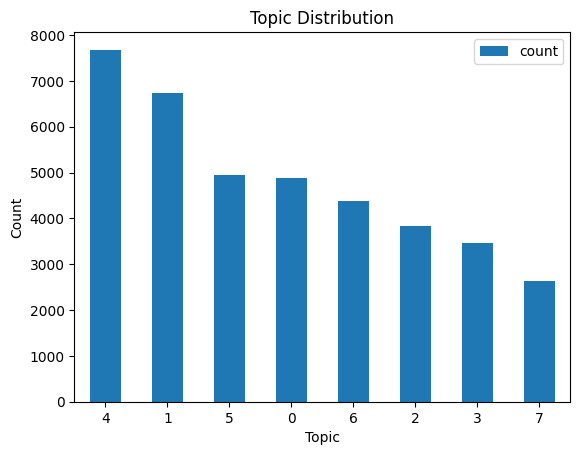

In [18]:
data = {
    'topic': [4,1,5,0,6,2,3,7],
    'count': [7681, 6730, 4953, 4887, 4370, 3825, 3466, 2640],
}

df = pd.DataFrame(data)
# create a histogram chart to show the distribution of the topics ranked from topic 0 to topic 11

df.plot(x ='topic', y='count', kind = 'bar', rot=0)
# add labels
plt.xlabel("Topic")
plt.ylabel("Count")
plt.title("Topic Distribution")

In [35]:
%%time
#ktrain
texts_full = df_news_final_project_filtered['cleaned_text_split_concatenated'].tolist() 

CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 23.3 ms


In [36]:
%%time
tm = ktrain.text.get_topic_model(
    texts=texts_full, 
    n_topics=8, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 8min 44s, sys: 2min 48s, total: 11min 32s
Wall time: 8min 2s


In [37]:
tm.print_topics()

topic 0 | use human learning people work research science like systems need
topic 1 | company stock investment financial year million shares billion market investors
topic 2 | news ago twitter email year world video facebook says republic
topic 3 | platform solutions business prnewswire customers cloud customer digital company leading
topic 4 | market report global analysis growth industry key research forecast players
topic 5 | health care medical healthcare patients clinical patient cancer statements policy
topic 6 | insurance smart power energy edge time computer vision based computing
topic 7 | chatgpt google users like openai content microsoft search use news


In [38]:
%%time
# Compute the Document-Topic Matrix
tm.build(texts_full, threshold=0.25)

done.
CPU times: user 2min 27s, sys: 28.2 s, total: 2min 55s
Wall time: 2min 20s


In [39]:
#list the topics by document count:

tm.print_topics(show_counts=True)

topic:3 | count:49995 | platform solutions business prnewswire customers cloud customer digital company leading
topic:2 | count:37161 | news ago twitter email year world video facebook says republic
topic:7 | count:31219 | chatgpt google users like openai content microsoft search use news
topic:0 | count:27940 | use human learning people work research science like systems need
topic:4 | count:14968 | market report global analysis growth industry key research forecast players
topic:1 | count:11443 | company stock investment financial year million shares billion market investors
topic:5 | count:10790 | health care medical healthcare patients clinical patient cancer statements policy
topic:6 | count:9852 | insurance smart power energy edge time computer vision based computing


In [43]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[4], rank=True)[0]['text'])

ARTIFICIAL INTELLIGENCE SERVICE INDUSTRY 2025 SIZE SHARE DEMAND KEY PLAYERS PROFILES AND MARKET ANALYSIS RESEARCH TO 2020 3w Market News Reports Skip to the content Search 3w Market News Reports3rd Market Reports and Analytics Menu Contact Us About Us Search Search for Close search Close Menu Contact Us About Us Categories Global News ARTIFICIAL INTELLIGENCE SERVICE INDUSTRY 2025 SIZE SHARE DEMAND KEY PLAYERS PROFILES AND MARKET ANALYSIS RESEARCH TO 2020 Post author By orian Post date July 2 2020 Global Artificial Intelligence Service Market Research Report estimates the size of the market for 2020 and projects its growth by 2025 It provides a detailed qualitative and quantitative analysis of the Global Artificial Intelligence Service market And collect useful data for this extensive commercial study of the Global Artificial Intelligence Service market The global Global Artificial Intelligence Service report is a basic hold of information essentially for the business executives Get Sam

In [44]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[4], rank=True)[300]['text'])

Comprehensive Report on Conversational AI Market 2020 Size Growth Demand Opportunities Forecast To 2026 Conversica Google Oracle Artificial Solutions Baidu Murphys Hockey Law Skip to content December 7 2020 Murphys Hockey Law Primary Menu All News Energy News Space Contact Search for HomeNewsComprehensive Report on Conversational AI Market 2020 Size Growth Demand Opportunities Forecast To 2026 Conversica Google Oracle Artificial Solutions Baidu Energy News Comprehensive Report on Conversational AI Market 2020 Size Growth Demand Opportunities Forecast To 2026 Conversica Google Oracle Artificial Solutions the existing top players and the upcoming competitors Business strategies of the key players and the new entering market industries are studied in detail Well explained SWOT analysis revenue share and contact information are shared in this report analysis Get the PDF Sample Copy (Including FULL TOC Graphs and Tables) of this report Note In order to provide more accurate market forecast 

In [46]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[2], rank=True)[30]['text'])

OH (44902) Today Partly cloudy skies early will give way to cloudy skies late Low 29F Winds ESE at 5 to 10 mph Tonight Partly cloudy skies early will give way to cloudy skies late Low 29F Winds ESE at 5 to 10 mph Updated December 13 2022 For more click here We want your feedback on the accuracy and quality of this article Take a 1 minute survey and be registered to win a 25 Visa gift card For statewide results and expert analysis of the best teams and prep athletes in Ohio sign up for our free newsletter Its required reading for high school sports fans This news brief was powered by ScoreStream and Lede AI the world leaders in fan driven sports results To see more game results from your favorite team OH 44902 Phone 419 610 2100 Email news Facebook Twitter LinkedIn YouTube Instagram Log In You are logged in Switch accounts Back Sign Up Username (Optional) This is the name that will be displayed next to your photo for comments blog posts and more Choose wisely Email Address Your e mail a

In [47]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[2], rank=True)[500]['text'])

Chinese artist Ai Weiwei says COVID protests will not Daily Mail Online Home U K News Sports U S Showbiz Australia Femail Health Science Money Video Travel Shop Wires Home My Profile Logout Login Privacy Policy Feedback Monday Nov 28th 2022 4PM 50 F 7PM 50 F 5 Day Forecast Advertisement Chinese artist Ai Weiwei says COVID protests will not shake government By Reuters Published 15 46 EST 28 November 2022 Updated 15 46 EST 28 November 2022 e mail Ai Weiwei says protests not likely to carry on Police will use force to silence protesters Movement lacks organisation and leadership By Catarina Demony MONTEMOR O NOVO Portugal Nov 28 (Reuters) From his Portuguese home Ai Weiwei the high profile Chinese dissident whose art has often criticized Beijings policies said the recent wave of protests would not shake Xi Jinpings government because the police would simply crush them into silence Protesters have taken to the streets of Shanghai Beijing and other cities in recent days to demonstrate again

In [48]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[2], rank=True)[3013]['text'])

Sobha Surendran brings CMs family into AI camera row demands oppositions response DH NEWS DH Latest News Kerala Latest News India NEWS Politics Opposition leader V D Satheesan Sobha Surendran Vigilance probe corruption Kerala politics BJP AI camera controversy Pinarayi Vijayan central agency probe Kerala employment security Tuesday May 2 2023 Breaking Sobha Surendran brings CM s family into AI camera row demands opposition s response Cancellation of flight operations DGCA issues showcause notice to Go First airlines Kerala Story creators abandon 32K claim demands opposition s response DH NEWSDH Latest NewsKeralaLatest NewsIndiaNEWSPolitics Sobha Surendran brings CM s family into AI camera row demands opposition s response May 2 2023 08 04 pm IST Facebook Twitter LinkedIn Pinterest Reddit WhatsApp Telegram BJP state vice president Sobha Surendran has accused Chief Minister Pinarayi Vijayan of being involved in the controversy surrounding the installation of Artificial Intelligence (AI) 

In [49]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[0], rank=True)[30]['text'])

What if AI could rebuild the middle class Monthly Guide Programs A Z Schedule Two Week Archive Ways to Listen Zounds Monthly Guide Programs A Z Schedule Two Week Archive Ways to Listen Zounds By Greg Rosalsky PublishedMay 9 2023 at 4 30 AM MDT Facebook Email Print Mohamed Hassan Pixabay We are witnessing a technological revolution unfolding in real time The rise of smart machines opens up some scary possibilities for our economy for our democracy even in the most catastrophic scenarios for our continued existence as a species But if we get our act together the age of Artificial Intelligence could be one in which we rebuild the middle class says MITs David Autor one of the top labor economists in the world Autor sees a potential future where we harness the power of AI to create a whole bunch of good jobs for people who have been left behind over the last few decades Even in this cheery scenario AI will profoundly disrupt the job market But Autor says with concerted efforts and smart pol

In [50]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[0], rank=True)[350]['text'])

2021 Posted in Centre for Information Policy Leadership European Union International On July 29 2021 including the Act s approach to regulating only high risk AI the definition of AI based on uses and not rigid sectors the reliance on industry self assessment to demonstrate product conformity the establishment of an AI innovation board and the inclusion of a statutory basis for regulatory sandboxes However CIPL reiterates that for the AI Act to be effective in protecting fundamental rights while also laying a foundation for a new era in EU innovation it needs to be flexible enough to adapt to future changes Further CIPL argues that the Act must not be overly restrictive so as to avoid suppressing valuable and beneficial innovations and uses of AI across a range of industries and sectors Finally CIPL proposes that the AI Act would benefit from targeted adjustments that better clarify the balance of responsibilities of AI providers deployers and users particularly for general purpose AI 

In [51]:
# Review top-ranked documents for a given topic
print(tm.get_docs(topic_ids=[0], rank=True)[1000]['text'])

Concrete Problems in AI Safety The paper explores many research problems around ensuring that modern machine learning systems operate as intended June 21 2016More resourcesRead paperSafety Alignment Robustness PublicationWe (along with researchers from Berkeley and Stanford) are co authors on today s paper led by Google Brain researchers Concrete Problems in AI Safety The paper explores many research problems around ensuring that modern machine learning systems operate as intended (The problems are very practical and we ve already seen some being integrated intoOpenAIGym )Advancing AI requires making AI systems smarter but it also requires preventing accidents that is ensuring that AI systems do what people actually want them to do There s been an increasing focus onsafety researchfrom the machine learning community such as a recentpaperfromDeepMindandFHI Still many machine learning researchers have wondered just how much safety research can be donetoday The authors discuss fiveareas S

In [40]:
doc_topics = tm.get_doctopics(topic_ids=[])
tm.visualize_documents(doc_topics=doc_topics)

/opt/conda/lib/python3.10/site-packages/ktrain/text/eda.py:551: UserWarning: visualize_documents method requires bokeh package: pip install bokeh
  warnings.warn(


In [41]:
doc_topics = tm.get_doctopics(topic_ids=[])
tm.visualize_documents(doc_topics=doc_topics)

Text(0.5, 1.0, 'Topic Distribution')

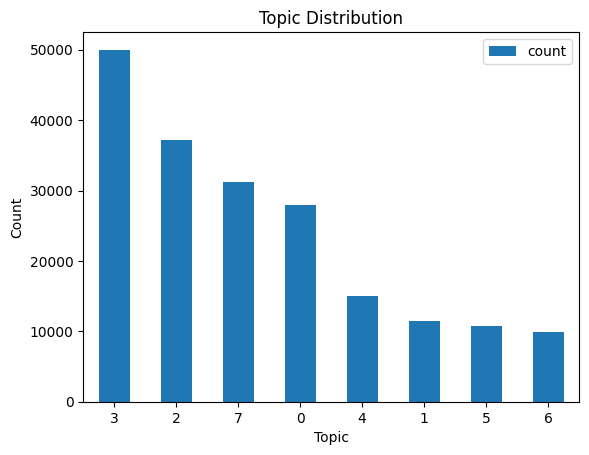

In [42]:
data = {
    'topic': [3,2,7,0,4,1,5,6],
    'count': [49995, 37161, 31219, 27940, 14968, 11443, 10790, 9852],
}

df = pd.DataFrame(data)
# create a histogram chart to show the distribution of the topics ranked from topic 0 to topic 11

df.plot(x ='topic', y='count', kind = 'bar', rot=0)
# add labels
plt.xlabel("Topic")
plt.ylabel("Count")
plt.title("Topic Distribution")